# Academy Award for Best Director

We first import the packages and load the csv files into dataframes

In [0]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
pd.options.mode.chained_assignment = None

In [2]:
bestdir_url = 'https://raw.githubusercontent.com/dcetin/academy-awards/master/best-director.csv?token=AD32IFU2AOHUJYINTWTU2N25Q2VF4'
ceremonies_url = 'https://raw.githubusercontent.com/dcetin/academy-awards/master/ceremonies.csv?token=AD32IFUN4ABRXTMM4YAEKHK5Q2VGU'
bestdir_df = pd.read_csv(bestdir_url)
ceremonies_df = pd.read_csv(ceremonies_url)
bestdir_df.tail()

,Ceremony,Won,Film,Director,Birthdate
448,91,False,BlacKkKlansman,Spike Lee,"March 20, 1957"
449,91,False,Cold War,Pawel Pawlikowski,"September 15, 1957"
450,91,False,The Favourite,Yorgos Lanthimos,"September 23, 1973"
451,91,True,Roma,Alfonso Cuaron,"November 28, 1961"
452,91,False,Vice,Adam McKay,"April 17, 1968"


We convert dates into datetime objects, append them as new columns. We also calculate ages using the timedeltas.

In [0]:
def get_ceremony_date(ceremonies_df, i):
  return ceremonies_df.iloc[ceremonies_df[ceremonies_df['Ceremony'] == i].index[0]]['date_dt']
def get_age(ceremonies_df, ceremony, birthdate, fmt='days'):
  if fmt == 'days':
    return (get_ceremony_date(ceremonies_df, ceremony) - birthdate).days
  elif fmt == 'str':
    rd = relativedelta(get_ceremony_date(ceremonies_df, ceremony), birthdate)
    return '{}y{}m{}d'.format(rd.years, rd.months, rd.days)
  elif fmt == 'float':
    rd = relativedelta(get_ceremony_date(ceremonies_df, ceremony), birthdate)
    return rd.years + (rd.months)/12.0 + (rd.days)/365.0

In [4]:
ceremonies_df['date_dt'] = pd.to_datetime(ceremonies_df['Date'].values, format='%B %d, %Y')
bestdir_df['birthdate_dt'] = pd.to_datetime(bestdir_df['Birthdate'].values, format='%B %d, %Y')
bestdir_df['age_float'] = bestdir_df.apply(lambda row: get_age(ceremonies_df, row['Ceremony'], row['birthdate_dt'], fmt='float'), axis=1)
bestdir_df.tail()

,Ceremony,Won,Film,Director,Birthdate,birthdate_dt,age_float
448,91,False,BlacKkKlansman,Spike Lee,"March 20, 1957",1957-03-20,61.927626
449,91,False,Cold War,Pawel Pawlikowski,"September 15, 1957",1957-09-15,61.441324
450,91,False,The Favourite,Yorgos Lanthimos,"September 23, 1973",1973-09-23,45.419406
451,91,True,Roma,Alfonso Cuaron,"November 28, 1961",1961-11-28,57.240639
452,91,False,Vice,Adam McKay,"April 17, 1968",1968-04-17,50.852511


We calculate some statistics and extract some filters which will come in handy when plotting the data.

In [0]:
female_dirs = ['Lina Wertmuller', 'Jane Campion', 'Sofia Coppola', 'Kathryn Bigelow', 'Greta Gerwig']
nominees = bestdir_df['Won'] == False
winners = bestdir_df['Won'] == True
females = bestdir_df['Director'].isin(female_dirs)
ages_per_ceremony = [bestdir_df['age_float'][bestdir_df['Ceremony']==i].values for i in range(1, len(ceremonies_df)+1)]
means = np.asarray([np.mean(x) for x in ages_per_ceremony])
stds = np.asarray([np.std(x) for x in ages_per_ceremony])
bestdir_df['color_nw'] = bestdir_df.apply(lambda row: 'red' if row['Won'] else 'black', axis=1).copy()
bestdir_df['color_mf'] = bestdir_df.apply(lambda row: 'red' if row['Director'] in female_dirs else 'blue', axis=1).copy()

We plot the winners and nominees by their age at the day of the award ceremony. 

In [12]:
fig = go.Figure(data=go.Scatter(x=bestdir_df['Ceremony'],
                                y=bestdir_df['age_float'],
                                mode='markers',
                                marker_color=bestdir_df['color_nw'],
                                # marker_color=bestdir_df['color_mf'],
                                text=bestdir_df['Director'] + ' (' + bestdir_df['Film'] + ')'))
fig.update_layout(title='Nominees through years by age')
fig.update_yaxes(zeroline=False, title='Age')
fig.update_xaxes(zeroline=False, title='Ceremony', tickvals=list(range(1, len(ceremonies_df)+1, 5)))
fig.show()

We plot them alongside the mean and variance per each ceremony to discern some outliers in terms of age.

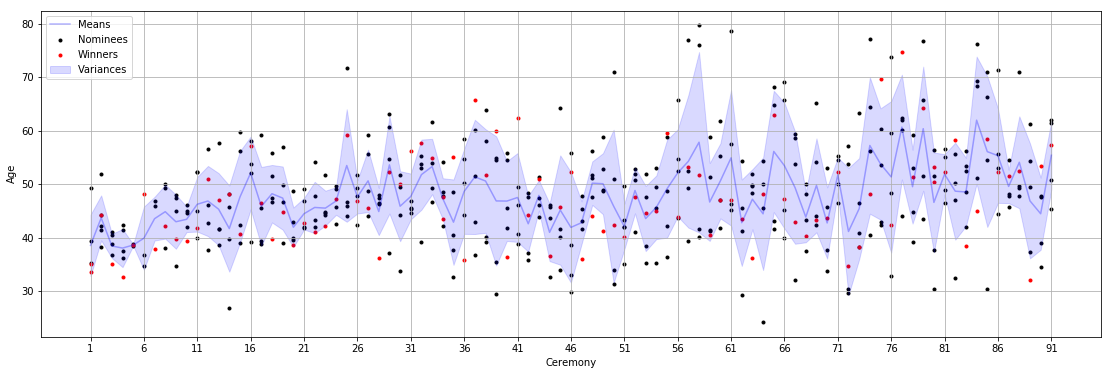

In [6]:
plt.figure(figsize=(19,6))
plt.scatter(bestdir_df['Ceremony'][nominees], bestdir_df['age_float'][nominees], marker='.', c='k', label='Nominees')
plt.scatter(bestdir_df['Ceremony'][winners], bestdir_df['age_float'][winners], marker='.', c='r', label='Winners')
plt.plot(ceremonies_df['Ceremony'], means, linestyle='-', c='b', alpha=0.3, label='Means')
plt.fill_between(ceremonies_df['Ceremony'], means-stds, means+stds, color='b', alpha=0.15, label='Variances')
plt.xticks(range(1, len(ceremonies_df)+1, 5))
plt.grid(True)
plt.ylabel('Age')
plt.xlabel('Ceremony')
plt.legend(loc='upper left')
plt.show()

We can also search a director by name and see how well he was received in Academy Awards throughout years.

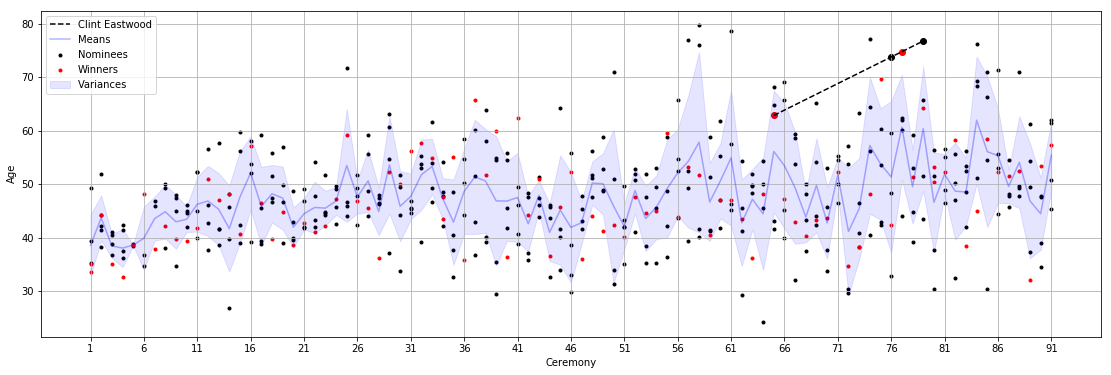

In [7]:
name = 'Clint Eastwood'
specifier = bestdir_df['Director'] == name
plt.figure(figsize=(19,6))
plt.scatter(bestdir_df['Ceremony'][nominees], bestdir_df['age_float'][nominees], marker='.', c='k', label='Nominees')
plt.scatter(bestdir_df['Ceremony'][winners], bestdir_df['age_float'][winners], marker='.', c='r', label='Winners')
plt.plot(bestdir_df['Ceremony'][specifier], bestdir_df['age_float'][specifier], linestyle='--', c='k', label=name)
plt.scatter(bestdir_df['Ceremony'][nominees & specifier], bestdir_df['age_float'][nominees & specifier], c='k', label='_nolegend_')
plt.scatter(bestdir_df['Ceremony'][winners & specifier], bestdir_df['age_float'][winners & specifier], c='r', label='_nolegend_')
plt.plot(ceremonies_df['Ceremony'], means, linestyle='-', c='b', alpha=0.3, label='Means')
plt.fill_between(ceremonies_df['Ceremony'], means-stds, means+stds, color='b', alpha=0.1, label='Variances')
plt.xticks(range(1, len(ceremonies_df)+1, 5))
plt.grid(True)
plt.ylabel('Age')
plt.xlabel('Ceremony')
plt.legend(loc='upper left')
plt.show()

Fitting a line to the ages of all nominees shows a visible increasethroughout years.

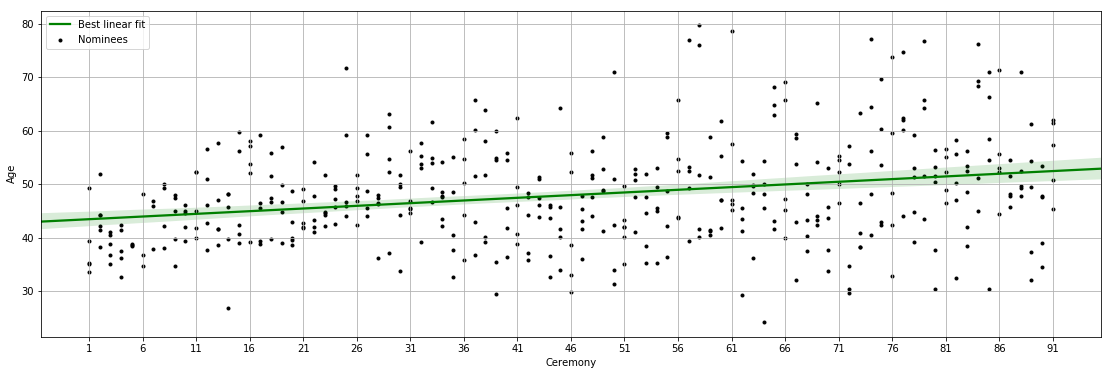

In [8]:
plt.figure(figsize=(19,6))
plt.scatter(bestdir_df['Ceremony'], bestdir_df['age_float'], marker='.', c='k', label='Nominees')
sns.regplot(x=bestdir_df['Ceremony'], y= bestdir_df['age_float'], color="g", marker='.', scatter=False, label='Best linear fit')
plt.xticks(range(1, len(ceremonies_df)+1, 5))
plt.grid(True)
plt.ylabel('Age')
plt.xlabel('Ceremony')
plt.legend(loc='upper left')
plt.show()